In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import dask.dataframe as dd
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
file = '311_Service_Requests_from_2010_to_Present.csv'
print(pd.read_csv(file,nrows=5))

   Unique Key            Created Date             Closed Date Agency  \
0    35449236  02/09/2017 07:00:55 PM  03/24/2017 11:41:38 AM  DOHMH   
1    35449237  02/09/2017 01:34:00 PM  02/16/2017 09:28:40 AM    DOT   
2    35449238  02/09/2017 03:12:07 PM  02/14/2017 03:35:33 PM    DOT   
3    35449239  02/09/2017 04:50:54 PM                     NaN    DPR   
4    35449240  02/09/2017 10:18:00 AM  02/12/2017 12:00:00 PM   DSNY   

                               Agency Name                     Complaint Type  \
0  Department of Health and Mental Hygiene                      Indoor Sewage   
1             Department of Transportation                  Broken Muni Meter   
2             Department of Transportation                 Sidewalk Condition   
3       Department of Parks and Recreation                   New Tree Request   
4                                 Bronx 03  Missed Collection (All Materials)   

                      Descriptor        Location Type  Incident Zip  \
0        

In [3]:
csv_database = create_engine('sqlite:///csv_database.db')
chunksize = 1000000
i = 0
j = 1
for df in pd.read_csv(file, chunksize=chunksize, iterator=True):
      df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
      df.index += j
      i+=1
      df.to_sql('nyc', csv_database, if_exists='append')
      j = df.index[-1] + 1

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8,17,31,32,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8,17,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8,17,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=inte

In [4]:
import sqlite3
conn = sqlite3.connect("csv_database.db")
sql = """
SELECT CreatedDate, ComplaintType   
FROM nyc
        """
df_data = pd.read_sql_query(sql, conn)
conn.close()

In [7]:
df_data["ComplaintType"].value_counts()

HEATING                                880472
Noise - Residential                    845556
Street Light Condition                 647854
Street Condition                       624443
HEAT/HOT WATER                         564643
PLUMBING                               554954
GENERAL CONSTRUCTION                   499901
Blocked Driveway                       416700
PAINT - PLASTER                        360577
Illegal Parking                        351442
Traffic Signal Condition               306520
NONCONST                               260423
General Construction/Plumbing          229887
ELECTRIC                               225309
UNSANITARY CONDITION                   199536
Water System                           181124
Noise - Street/Sidewalk                179842
Building/Use                           177037
Damaged Tree                           176914
PAINT/PLASTER                          171814
Noise - Commercial                     156299
Rodent                            

In [10]:
df_data.shape

(11705005, 2)

In [5]:
noise_msk=df_data["ComplaintType"].str.contains("Noise",na=False) 
parking_msk=df_data["ComplaintType"].str.contains("Parking",na=False) 
heating_msk=df_data["ComplaintType"].str.contains("HEAT",na=False)
plumbing_msk=df_data["ComplaintType"].str.contains("PLUMBING",na=False) 
street_msk=df_data["ComplaintType"].str.contains("Street Condition",na=False) 
streetlight=df_data["ComplaintType"].str.contains("Street Light Condition",na=False) 
paint_msk=df_data["ComplaintType"].str.contains("Noise",na=False) 
construction_msk=df_data["ComplaintType"].str.contains("CONSTRUCTION",na=False) 

In [19]:
labels=["Noise","Parking","Heating","Plumbing","Street","Street Light","Paint","Construction","Others"]
sizes=[df_data[noise_msk].shape[0],df_data[parking_msk].shape[0], \
      df_data[heating_msk].shape[0],df_data[plumbing_msk].shape[0], \
      df_data[street_msk].shape[0],df_data[streetlight].shape[0], \
      df_data[paint_msk].shape[0], df_data[construction_msk].shape[0], \
      df_data.shape[0]-df_data[noise_msk].shape[0]-df_data[parking_msk].shape[0]- \
      df_data[heating_msk].shape[0]-df_data[plumbing_msk].shape[0]- \
      df_data[street_msk].shape[0]-df_data[streetlight].shape[0]- \
      df_data[paint_msk].shape[0]- df_data[construction_msk].shape[0]]
explode =(0.1,0,0,0,0,0,0,0,0)



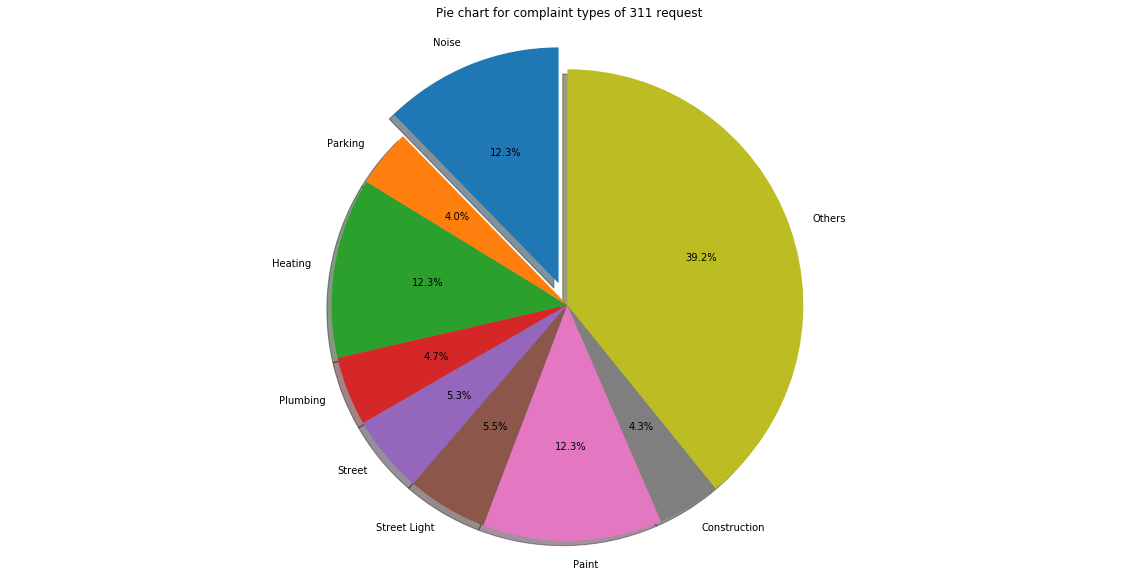

In [24]:
##1st interesting plot
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Pie chart for complaint types of 311 request")

plt.show()

In [6]:
##excluded invalid date
df_data['CreatedDate'] = pd.to_datetime(df_data['CreatedDate'])
df_data = df_data[pd.to_numeric(df_data['CreatedDate'], errors='coerce').notnull()]
df_data['CreatedDate'] = df_data['CreatedDate'].astype('datetime64[ns]')



In [7]:
mask18=(df_data['DATE'] <'2019-01-01') & (df_data['DATE'] >'2017-12-31')
df_data[noise_msk].groupby(pd.Grouper(key='CreatedDate',freq='M')).size()


CreatedDate
2010-01-31    13074
2010-02-28    11807
2010-03-31    12678
2010-04-30    15643
2010-05-31    18620
2010-06-30    14671
2010-07-31    13823
2010-08-31    16180
2010-09-30    16602
2010-10-31    16429
2010-11-30    13195
2010-12-31    11565
2011-01-31    13371
2011-02-28    12758
2011-03-31    14721
2011-04-30    15998
2011-05-31    19750
2011-06-30    18232
2011-07-31    17610
2011-08-31    16996
2011-09-30    20594
2011-10-31    18979
2011-11-30    16612
2011-12-31    16141
2012-01-31    13713
2012-02-29    12855
2012-03-31    15469
2012-04-30    16139
2012-05-31    19622
2012-06-30    18851
              ...  
2016-10-31      170
2016-11-30      128
2016-12-31     1969
2017-01-31      961
2017-02-28    19882
2017-03-31    27535
2017-04-30    41132
2017-05-31    42736
2017-06-30    47089
2017-07-31    44250
2017-08-31    41862
2017-09-30    45390
2017-10-31    41471
2017-11-30    28915
2017-12-31    27597
2018-01-31    25913
2018-02-28    23993
2018-03-31    28979
2018-04-

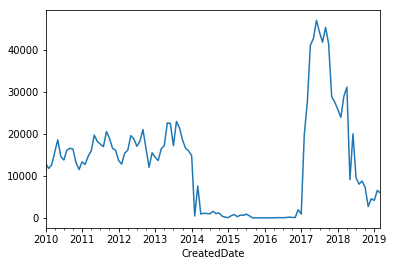

In [19]:
#csv_database = create_engine('sqlite:///csv2c_database.db')
#df_data.to_sql('nyc', csv_database,if_exists='append')
groups=df_data[noise_msk].groupby(pd.Grouper(key='CreatedDate',freq='M')).size()
groups.plot.line()